# Portfolio Allocation based on Financial Performance

In [ ]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#import dataset from git
url_DS_ESGScore_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_ESGScore_Y.csv'
DS_ESGScore_Y = pd.read_csv(url_DS_ESGScore_Y)

url_DS_EScore_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_EScore_Y.csv'
DS_EScore_Y = pd.read_csv(url_DS_EScore_Y)

url_DS_MV_USD_M = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_MV_USD_M.csv'
DS_MV_USD_M = pd.read_csv(url_DS_MV_USD_M)

url_DS_MV_USD_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_MV_USD_Y.csv'
DS_MV_USD_Y = pd.read_csv(url_DS_MV_USD_M)

url_DS_REV_USD_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_REV_USD_Y.csv'
DS_REV_USD_Y = pd.read_csv(url_DS_REV_USD_Y)

url_DS_RI_USD_M = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_RI_USD_M.csv'
DS_RI_USD_M = pd.read_csv(url_DS_RI_USD_M)

url_DS_RI_USD_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_RI_USD_Y.csv'
DS_RI_USD_Y = pd.read_csv(url_DS_RI_USD_M)

url_Risk_Free_Rate = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/Risk_Free_Rate.csv'
Risk_Free_Rate = pd.read_csv(url_Risk_Free_Rate)

url_Static = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/Static.csv'
Static = pd.read_csv(url_Static)


<ipython-input-83-c9f8fe89ee9e>:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  DS_MV_USD_M = pd.read_csv(url_DS_MV_USD_M)
<ipython-input-83-c9f8fe89ee9e>:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  DS_MV_USD_Y = pd.read_csv(url_DS_MV_USD_M)


### Test data sets

## Question 1: Average annualized return and volatiliy (10 points)

In [ ]:
# idea: for annualized, sum up all months r and divide by the total number of months, multiply by 12
# for the other: annualized volatility, same thing with volatility

## Question 2: Equally-weighted/market-cap (value) weighted portfolios (15 points)

### Risk free rate

In [ ]:
Risk_Free_Rate.head()

,Unnamed: 0,RF
0,200001,0.41
1,200002,0.43
2,200003,0.47
3,200004,0.46
4,200005,0.50


In [ ]:
import calendar

df = Risk_Free_Rate.copy()

df[df.columns[0]] = df[df.columns[0]].astype(str)

# Extract year (first 4 characters) and month (characters 5-6)
df['Year'] = df.iloc[:, 0].str[:4].astype(int)
df['Month'] = df.iloc[:, 0].str[4:6].astype(int)  # Extract month

# Get the last day of the month using calendar.monthrange
df['LastDay'] = df.apply(lambda row: calendar.monthrange(row['Year'], row['Month'])[1], axis=1)
# Rename 'LastDay' to 'Day' for pd.to_datetime
df = df.rename(columns={'LastDay': 'Day'}) # Rename to 'Day' to match expected input for pd.to_datetime

# Now create the 'ReadableDate' column using the calculated LastDay
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']]) # Use 'Day' instead of 'LastDay'

# Drop the temporary 'Year', 'Month', and 'Day' columns
df = df.drop(['Year', 'Month', 'Day', 'Unnamed: 0' ], axis=1)

df = df[['date', 'RF']]

df['date'] = pd.to_datetime(df['date'])
df['RF'] = df['RF'] / 100

#df["RF"] = (1 + df["RF"]) ** (1/12) - 1
#df['RF'] = df['RF'] / 12

risk_free_rate_df = df

risk_free_rate_df.tail(100)

,date,RF
200,2016-09-30,0.0002
201,2016-10-31,0.0002
202,2016-11-30,0.0001
203,2016-12-31,0.0003
204,2017-01-31,0.0004
...,...,...
295,2024-08-31,0.0048
296,2024-09-30,0.0040
297,2024-10-31,0.0039
298,2024-11-30,0.0040


### Region selection

In [ ]:
region = 'EM'

### Simple returns

In [ ]:
# Merging the data to filter per region
merged_DS_RI_USD_M = pd.merge(DS_RI_USD_M, Static, on='ISIN', how='inner')
merged_DS_RI_USD_M = merged_DS_RI_USD_M[['ISIN', 'Name', 'Country', 'Region'] + [col for col in merged_DS_RI_USD_M.columns if col not in ['ISIN', 'Name', 'Country', 'Region']]]
del(merged_DS_RI_USD_M['NAME'])
merged_DS_RI_USD_M.head(10)

# Filter on EM countries
EM_merged_DS_RI_USD_M = merged_DS_RI_USD_M[merged_DS_RI_USD_M['Region'] == region]

In [ ]:
years = [str(year) for year in range(2013, 2024)]

# Select only the columns that are in the 'years' list
DS_ESGScore_Y_filtered = DS_ESGScore_Y[['NAME','ISIN', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']]

In [ ]:
# Make a copy to avoid modifying the original DataFrame directly
df_filled = DS_ESGScore_Y_filtered.copy()

# Identify the year columns (assuming they are strings representing years)
year_columns = sorted([col for col in df_filled.columns if col.isdigit()])

# Iterate through the year columns
for i in range(1, len(year_columns)):
    prev_year = year_columns[i-1]
    current_year = year_columns[i]

    # Create a mask to select rows where:
    # 1. The current year is NaN
    # 2. The previous year is NOT NaN
    # 3. The previous year's value is a float
    mask = (df_filled[current_year].isna()) & \
           (df_filled[prev_year].notna()) & \
           (df_filled[prev_year].apply(lambda x: isinstance(x, (int, float)))) #check if int or float (not only float)

    # Fill the NaN values in the current year with the previous year's float value
    df_filled.loc[mask, current_year] = df_filled.loc[mask, prev_year]

# Update DS_ESGScore_Y_filtered with the filled values
DS_ESGScore_Y_filtered = df_filled

In [ ]:
DS_ESGScore_Y_filtered.shape

(2508, 13)

In [ ]:
DS_ESGScore_Y_filtered = DS_ESGScore_Y_filtered.dropna()

In [ ]:
DS_ESGScore_Y_filtered.shape

(2317, 13)

In [ ]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is named 'df'

# Check if there are any NaN values in the DataFrame
has_nan = DS_ESGScore_Y_filtered.isna().any().any()

if has_nan:
    print("The DataFrame still contains NaN values.")

    # Get the count of NaN values in each column
    nan_counts = DS_ESGScore_Y_filtered.isna().sum()

    # Display columns with NaN values and their counts
    print("\nColumns with NaN values:")
    for column, count in nan_counts[nan_counts > 0].items():
        print(f"{column}: {count} NaN values")

    # Get the total number of NaN values
    total_nan = DS_ESGScore_Y_filtered.isna().sum().sum()
    print(f"\nTotal number of NaN values: {total_nan}")

    # Optionally, you can display rows with NaN values
    rows_with_nan = DS_ESGScore_Y_filtered[DS_ESGScore_Y_filtered.isna().any(axis=1)]
    print("\nRows containing NaN values:")
    print(rows_with_nan)
else:
    print("The DataFrame does not contain any NaN values.")


The DataFrame does not contain any NaN values.


In [ ]:
EM_merged_DS_RI_USD_M.shape

(710, 306)

In [ ]:
EM_merged_DS_RI_USD_M = EM_merged_DS_RI_USD_M[EM_merged_DS_RI_USD_M['ISIN'].isin(DS_ESGScore_Y_filtered['ISIN'])]
EM_merged_DS_RI_USD_M.shape

(585, 306)

In [ ]:
EM_merged_DS_RI_USD_M.columns = list(EM_merged_DS_RI_USD_M.columns[:4]) + list(pd.to_datetime(EM_merged_DS_RI_USD_M.columns[4:]))

start_date = pd.to_datetime('2013-12-31 00:00:00')
end_date = pd.to_datetime('2024-12-31 00:00:00')

EM_merged_DS_RI_USD_M_2014_2024 = EM_merged_DS_RI_USD_M.loc[:, start_date:end_date]

#EM_merged_DS_RI_USD_M_2014_2024 = pd.concat([EM_merged_DS_RI_USD_M.iloc[:, :4], EM_merged_DS_RI_USD_M_2014_2024], axis=1)

EM_merged_DS_RI_USD_M_2014_2024

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29,2024-12-31
118,18.66,17.10,17.59,14.98,13.98,13.19,12.93,13.94,14.17,12.83,...,0.63,0.59,0.59,0.56,0.51,0.59,0.62,0.80,0.67,0.63
146,2413.60,2216.92,2411.18,2506.51,2452.27,2377.43,2404.19,2347.97,2473.31,2223.15,...,1199.78,1127.14,1057.57,987.73,985.01,1091.85,1154.89,1049.92,1025.18,963.62
147,586.09,488.82,505.41,585.72,607.19,590.46,663.78,720.25,923.06,616.28,...,1272.70,1190.47,1161.15,1109.30,1083.48,1164.81,1178.58,1074.08,998.11,947.95
148,2057.95,1807.78,1961.79,2326.29,2505.91,2353.38,2464.89,2596.12,3109.24,2428.24,...,1893.69,1797.94,1607.05,1495.68,1489.17,1884.13,1854.74,1719.88,1477.92,1316.83
149,5199.92,4485.87,4616.20,5043.88,5677.09,5400.01,6087.05,6202.06,6778.56,6020.11,...,902.28,901.27,978.31,1129.50,1031.04,1281.75,1201.84,1253.98,1177.39,1168.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,133.73,122.77,131.88,137.09,136.36,152.40,151.61,149.66,148.46,133.89,...,103.80,108.05,121.84,131.64,173.36,175.55,184.07,190.50,209.13,210.60
2561,327.12,301.54,319.77,378.57,390.79,389.10,405.67,417.69,418.57,373.04,...,373.17,386.72,396.75,434.53,439.89,495.99,531.01,497.48,498.09,524.49
2562,31.88,29.65,31.25,29.43,30.95,31.93,34.00,32.65,31.92,25.91,...,53.35,59.43,61.64,62.37,70.16,53.12,56.97,66.32,56.06,46.48
2563,59.61,49.36,48.80,50.87,50.67,52.74,51.38,53.56,50.71,46.44,...,0.05,0.05,0.05,0.06,0.08,0.09,0.09,0.08,0.10,0.10


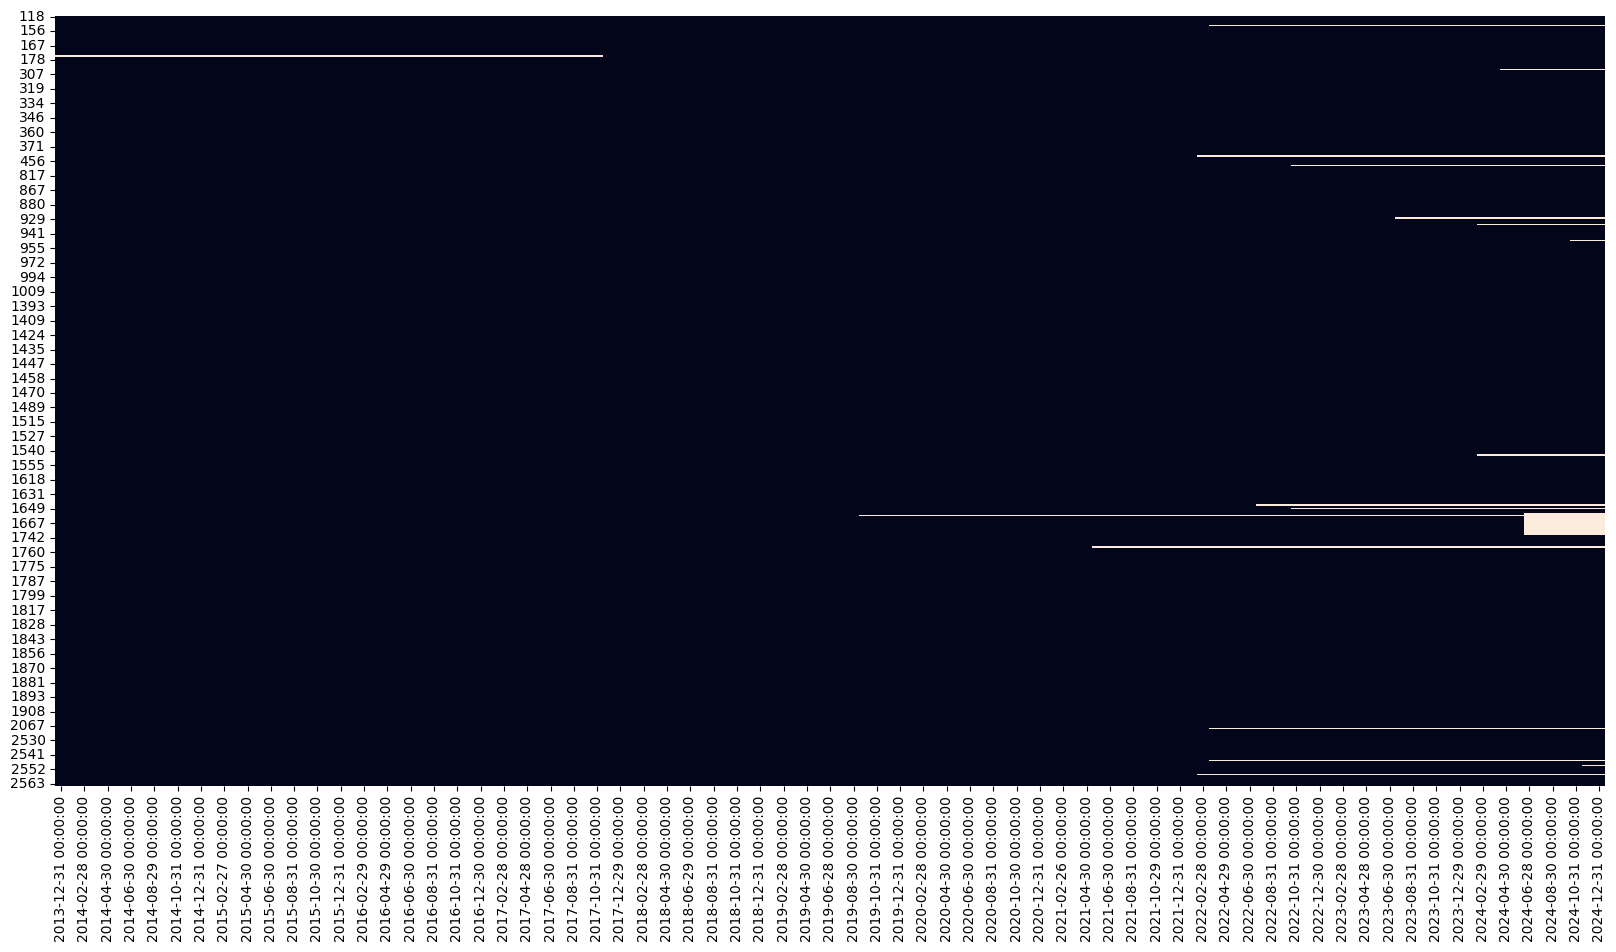

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(EM_merged_DS_RI_USD_M_2014_2024.isnull(), cbar=False)
plt.show()

In [ ]:
nan_rows = EM_merged_DS_RI_USD_M_2014_2024[EM_merged_DS_RI_USD_M_2014_2024.isnull().any(axis=1)]

nan_row_indices = nan_rows.index.tolist()

nan_row_indices

company_names = EM_merged_DS_RI_USD_M.loc[nan_row_indices, 'Name']

company_names

,Name
152,CMPH.ENGT.DE SAOP.B PN DEAD - DELIST.29/03/22
175,SUZANO ON
302,AES ANDES DEAD - DELIST.18/04/24
378,TELF.O2 CZECH REPUBLIC DEAD - DELIST.25/02/22
722,LAMPRELL DEAD - DELIST.25/10/22
928,HOUSING DEVELOPMENT FINANCE CORPORATION
934,RELIANCE CAPITAL SUSP - SUSP.29/02/24
946,IDFC DEAD - DELIST.11/10/24
1544,UMW HOLDINGS DEAD - DELIST.19/02/24
1646,GRUPA LOTOS DEAD - DELIST.12/08/22


In [ ]:
# Filter out company names that do not contain "SUSP" or "DELIST"
filtered_indices = company_names[~company_names.str.contains("SUSP|DELIST", case=False, na=False)].index.tolist()

filtered_indices

[175,
 928,
 1660,
 1661,
 1662,
 1663,
 1664,
 1665,
 1666,
 1667,
 1668,
 1669,
 1670,
 1671,
 1672,
 1673,
 1674,
 1675,
 2549]

In [ ]:
selected_rows = EM_merged_DS_RI_USD_M_2014_2024.loc[filtered_indices]
selected_rows

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29,2024-12-31
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69.25,61.11,50.20,55.61,51.62,52.62,54.16,55.94,56.62,55.94
928,725.10,728.27,746.08,835.33,840.28,837.49,931.42,1010.12,1013.25,977.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1660,72.88,67.75,73.82,74.04,79.72,84.71,90.80,91.03,89.69,85.16,...,182.48,184.07,173.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1661,5.01,4.65,4.38,4.57,4.23,4.26,4.44,3.70,3.49,3.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1662,54.00,52.72,49.54,49.32,46.21,51.99,55.94,49.69,47.79,46.84,...,45.62,46.90,37.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1663,24.84,23.10,20.26,17.22,15.82,17.47,18.64,18.73,20.32,20.19,...,14.53,13.65,13.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1664,95.46,86.87,84.01,85.78,81.13,86.83,91.95,88.79,87.74,80.67,...,289.40,306.90,306.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1665,324.56,283.52,267.42,251.41,214.46,255.56,271.46,225.61,215.92,208.86,...,544.61,556.55,584.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1666,57.79,50.64,53.60,51.91,52.05,52.88,59.43,56.42,58.14,55.47,...,155.57,159.39,158.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1667,6.32,5.23,5.38,4.93,4.54,5.49,5.44,6.38,6.44,6.64,...,35.51,36.10,34.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rows_with_nans_returns = selected_rows

In [ ]:
EM_merged_DS_RI_USD_M_2014_2024 = EM_merged_DS_RI_USD_M_2014_2024.drop(rows_with_nans_returns.index)

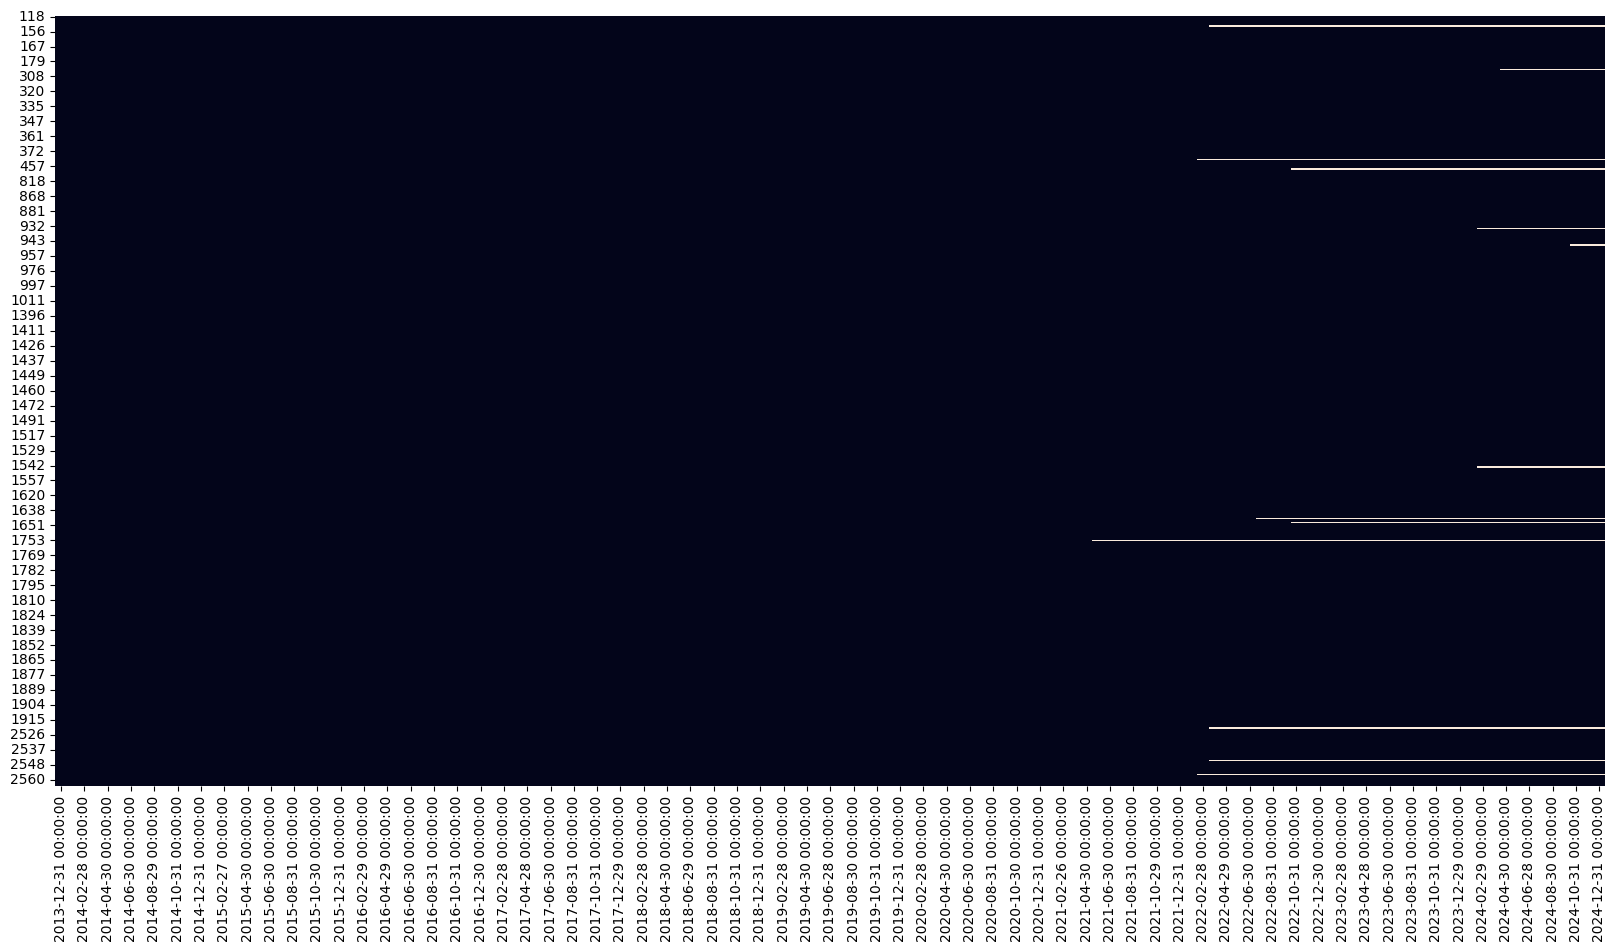

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(EM_merged_DS_RI_USD_M_2014_2024.isnull(), cbar=False)
plt.show()

In [ ]:
EM_merged_DS_RI_USD_M_2014_2024 = EM_merged_DS_RI_USD_M_2014_2024.fillna(0)

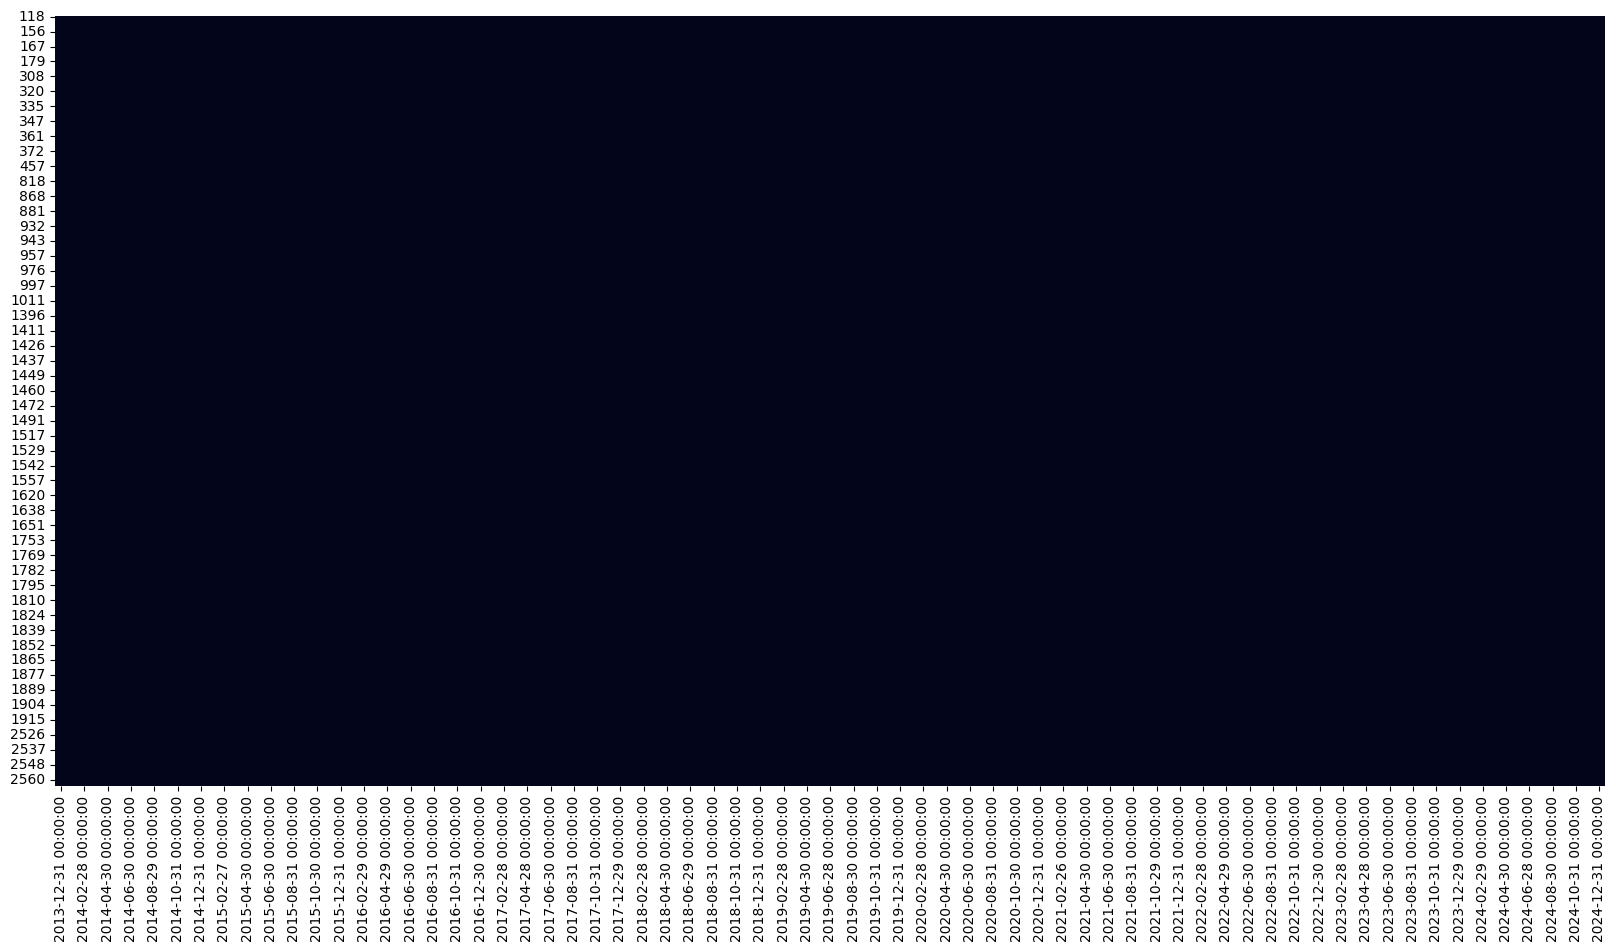

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(EM_merged_DS_RI_USD_M_2014_2024.isnull(), cbar=False)
plt.show()

In [ ]:
EM_merged_DS_RI_USD_M_2014_2024.isnull().sum().sum()

0

In [ ]:
df = EM_merged_DS_RI_USD_M_2014_2024.copy() # duplicate RI df

simple_returns_M = df.pct_change(axis=1, fill_method=None) # calucate the percentage increase (simple returns) from year to year (ignoring the NAME and ISIN column)

simple_returns_M.replace([np.inf], 0, inplace=True) # to deal with infinite growth (o to some stock value), these jumps replaced by NaN, not sure about this!!!

simple_returns_M.fillna(0, inplace=True)

simple_returns_M.replace([-np.inf], -1, inplace=True)

simple_returns_M_2014_2024 = simple_returns_M.iloc[:, 1:]

simple_returns_M_2014_2024

,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,2014-10-31,...,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29,2024-12-31
118,-0.083601,0.028655,-0.148380,-0.066756,-0.056509,-0.019712,0.078113,0.016499,-0.094566,-0.030398,...,-0.045455,-0.063492,0.000000,-0.050847,-0.089286,0.156863,0.050847,0.290323,-0.162500,-0.059701
146,-0.081488,0.087626,0.039537,-0.021640,-0.030519,0.011256,-0.023384,0.053382,-0.101144,0.035225,...,-0.014473,-0.060544,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564,-0.060048
147,-0.165964,0.033939,0.158901,0.036656,-0.027553,0.124174,0.085073,0.281583,-0.332351,0.094324,...,-0.021737,-0.064611,-0.024629,-0.044654,-0.023276,0.075064,0.011822,-0.088666,-0.070730,-0.050255
148,-0.121563,0.085193,0.185800,0.077213,-0.060868,0.047383,0.053240,0.197649,-0.219025,0.072200,...,0.030787,-0.050563,-0.106172,-0.069301,-0.004353,0.265222,-0.015599,-0.072711,-0.140684,-0.108998
149,-0.137319,0.029053,0.092648,0.125540,-0.048807,0.127229,0.018894,0.092953,-0.111890,0.105586,...,0.072827,-0.001119,0.085479,0.154542,-0.087171,0.243162,-0.062344,0.043383,-0.061078,-0.007831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,-0.081956,0.074204,0.039506,-0.005325,0.117630,-0.005184,-0.012862,-0.008018,-0.098141,-0.148107,...,0.082942,0.040944,0.127626,0.080433,0.316925,0.012633,0.048533,0.034932,0.097795,0.007029
2561,-0.078198,0.060456,0.183882,0.032279,-0.004325,0.042585,0.029630,0.002107,-0.108775,0.155667,...,-0.082512,0.036311,0.025936,0.095224,0.012335,0.127532,0.070606,-0.063144,0.001226,0.053002
2562,-0.069950,0.053963,-0.058240,0.051648,0.031664,0.064829,-0.039706,-0.022358,-0.188283,-0.056349,...,0.052891,0.113964,0.037187,0.011843,0.124900,-0.242873,0.072477,0.164121,-0.154704,-0.170888
2563,-0.171951,-0.011345,0.042418,-0.003932,0.040853,-0.025787,0.042429,-0.053211,-0.084204,-0.067614,...,-0.166667,0.000000,0.000000,0.200000,0.333333,0.125000,0.000000,-0.111111,0.250000,0.000000


In [ ]:
indices_cut_returns = simple_returns_M_2014_2024.index.tolist()

In [ ]:
simple_returns_M_2014_2024.isnull().sum().sum()

0

In [ ]:
simple_returns_M_2014_2024_prev = simple_returns_M.copy()

simple_returns_M_2014_2024_prev.columns = list(simple_returns_M_2014_2024_prev.columns[:4]) + list(pd.to_datetime(simple_returns_M_2014_2024_prev.columns[4:]))

start_date = pd.to_datetime('2013-12-31 00:00:00')
end_date = pd.to_datetime('2024-11-29 00:00:00')

simple_returns_M_2014_2024_prev = simple_returns_M_2014_2024_prev.loc[:, start_date:end_date]

simple_returns_M_2014_2024_prev = simple_returns_M_2014_2024_prev.apply(lambda row: row.fillna(row.mean()), axis=1) # fill nan with mean

simple_returns_M_2014_2024_prev

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-02-29,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29
118,0.0,-0.083601,0.028655,-0.148380,-0.066756,-0.056509,-0.019712,0.078113,0.016499,-0.094566,...,-0.014925,-0.045455,-0.063492,0.000000,-0.050847,-0.089286,0.156863,0.050847,0.290323,-0.162500
146,0.0,-0.081488,0.087626,0.039537,-0.021640,-0.030519,0.011256,-0.023384,0.053382,-0.101144,...,-0.043564,-0.014473,-0.060544,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564
147,0.0,-0.165964,0.033939,0.158901,0.036656,-0.027553,0.124174,0.085073,0.281583,-0.332351,...,0.034190,-0.021737,-0.064611,-0.024629,-0.044654,-0.023276,0.075064,0.011822,-0.088666,-0.070730
148,0.0,-0.121563,0.085193,0.185800,0.077213,-0.060868,0.047383,0.053240,0.197649,-0.219025,...,-0.108033,0.030787,-0.050563,-0.106172,-0.069301,-0.004353,0.265222,-0.015599,-0.072711,-0.140684
149,0.0,-0.137319,0.029053,0.092648,0.125540,-0.048807,0.127229,0.018894,0.092953,-0.111890,...,0.076436,0.072827,-0.001119,0.085479,0.154542,-0.087171,0.243162,-0.062344,0.043383,-0.061078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,0.0,-0.081956,0.074204,0.039506,-0.005325,0.117630,-0.005184,-0.012862,-0.008018,-0.098141,...,0.002615,0.082942,0.040944,0.127626,0.080433,0.316925,0.012633,0.048533,0.034932,0.097795
2561,0.0,-0.078198,0.060456,0.183882,0.032279,-0.004325,0.042585,0.029630,0.002107,-0.108775,...,-0.031918,-0.082512,0.036311,0.025936,0.095224,0.012335,0.127532,0.070606,-0.063144,0.001226
2562,0.0,-0.069950,0.053963,-0.058240,0.051648,0.031664,0.064829,-0.039706,-0.022358,-0.188283,...,-0.156905,0.052891,0.113964,0.037187,0.011843,0.124900,-0.242873,0.072477,0.164121,-0.154704
2563,0.0,-0.171951,-0.011345,0.042418,-0.003932,0.040853,-0.025787,0.042429,-0.053211,-0.084204,...,0.000000,-0.166667,0.000000,0.000000,0.200000,0.333333,0.125000,0.000000,-0.111111,0.250000


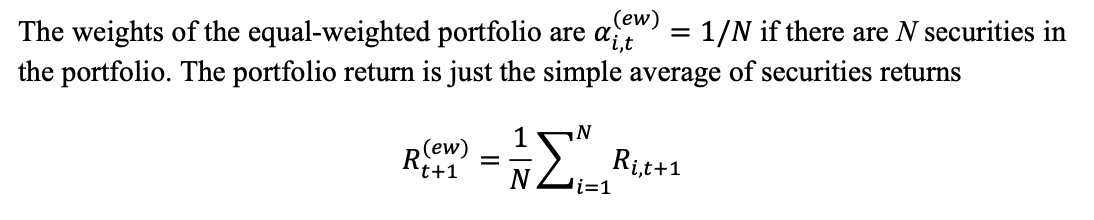

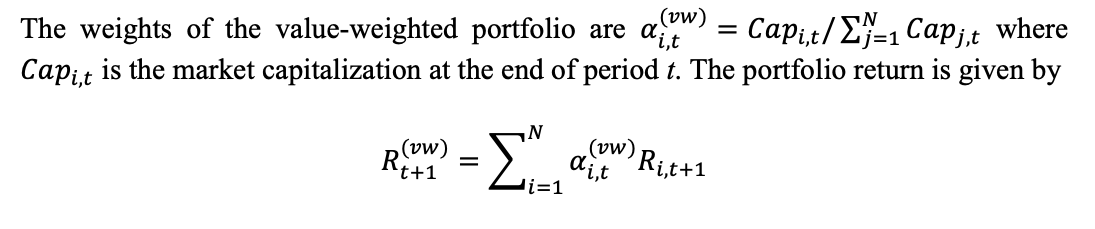

### Market Cap

In [ ]:
Static_filtered = Static[['ISIN', 'Region']]

merged_DS_MV_USD_M = pd.merge(DS_MV_USD_M, Static_filtered, on='ISIN', how='inner')

# Move 'Desired_Column' to position 2 (index-based, 0 is first column)
col_to_move = 'Region'
new_position = 2  # Adjust the index to where you want it

# Remove the column and re-insert it at the new position
col = merged_DS_MV_USD_M.pop(col_to_move)
merged_DS_MV_USD_M.insert(new_position, col_to_move, col)


# Filter on EM countries
EM_merged_DS_MV_USD_M = merged_DS_MV_USD_M[merged_DS_MV_USD_M['Region'] == region]

EM_merged_DS_MV_USD_M

,NAME,ISIN,Region,1999-12-31 00:00:00,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-28 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,...,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00,2025-01-31 00:00:00
1,ALUAR,ARALUA010258,EM,1129.31,1328.64,1395.07,1362.23,1340.19,1317.78,1209.89,...,2698.60,3165.16,3033.34,2875.18,2694.70,2494.63,2381.96,2635.60,2425.22,2291.70
2,BANCO BBVA ARGENTINA,ARP125991090,EM,1656.3,1570.39,1851.34,1656.82,1388.70,1352.22,1541.05,...,2435.11,3210.54,2818.34,2409.49,2832.34,2697.85,3274.73,3745.74,4516.58,5131.45
3,TERNIUM ARGENTINA SOCIEDAD ANONIMA,ARSIDE010029,EM,1414.37,1407.47,1463.08,1460.01,1356.04,893.05,955.70,...,4340.63,5146.56,4829.15,4589.92,3971.89,3870.75,3641.89,4278.73,3903.71,3645.50
118,CHINA YURUN FOOD GROUP,BMG211591018,EM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.82,36.81,35.25,32.20,37.15,39.19,50.41,42.16,39.42,35.09
146,AMBEV ON,BRABEVACNOR1,EM,898.33,848.69,810.12,1064.46,1062.92,1017.51,1287.05,...,36938.22,34658.22,32369.65,32280.60,35781.82,37847.65,34407.58,33596.80,29944.81,29942.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,ALTRON LIMITED A,ZAE000191342,EM,105.41,115.91,106.13,113.98,90.17,76.58,74.37,...,248.89,280.70,295.36,388.98,393.90,413.00,427.45,460.04,463.34,472.18
2561,ABSA GROUP,ZAE000255915,EM,2882.25,2649.35,2483.04,2348.10,2295.91,2374.43,2458.35,...,6906.91,7086.12,7760.90,7856.60,8858.64,9105.44,8530.48,8540.85,8993.55,8893.95
2562,NORTHAM PLATINUM HLDGS,ZAE000298253,EM,230.57,259.71,207.52,249.66,193.50,206.19,264.77,...,2632.31,2730.05,2762.38,3107.39,2352.88,2507.23,2918.45,2467.31,2045.45,2687.92
2563,AVENG,ZAE000302618,EM,436.66,445.83,454.09,389.04,351.95,276.11,312.53,...,42.32,39.84,48.32,61.15,71.10,70.09,66.52,78.76,84.89,83.96


In [ ]:
EM_merged_DS_MV_USD_M = EM_merged_DS_MV_USD_M.loc[indices_cut_returns]


In [ ]:
DS_MV_USD_M = EM_merged_DS_MV_USD_M.copy()

DS_MV_USD_M.columns = list(DS_MV_USD_M.columns[:3]) + list(pd.to_datetime(DS_MV_USD_M.columns[3:]))

start_date = pd.to_datetime('2013-12-31 00:00:00')
end_date = pd.to_datetime('2024-11-29 00:00:00')

DS_MV_USD_M_2014_2024 = DS_MV_USD_M.loc[:, start_date:end_date]

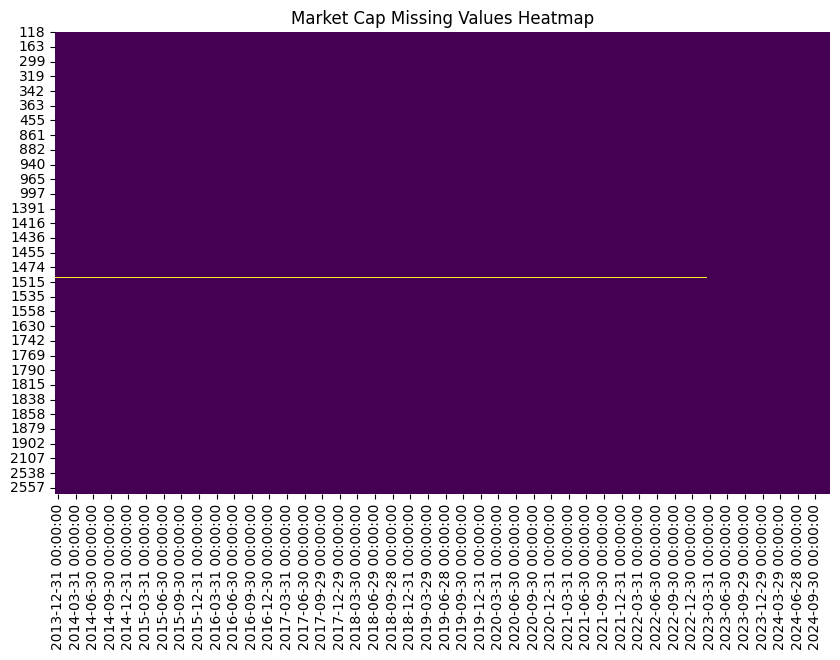

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(DS_MV_USD_M_2014_2024.isna(), cmap='viridis', cbar=False)
plt.title("Market Cap Missing Values Heatmap")
plt.show()

In [ ]:
DS_MV_USD_M_2014_2024 = DS_MV_USD_M_2014_2024.apply(lambda row: row.fillna(row.mean()), axis=1)

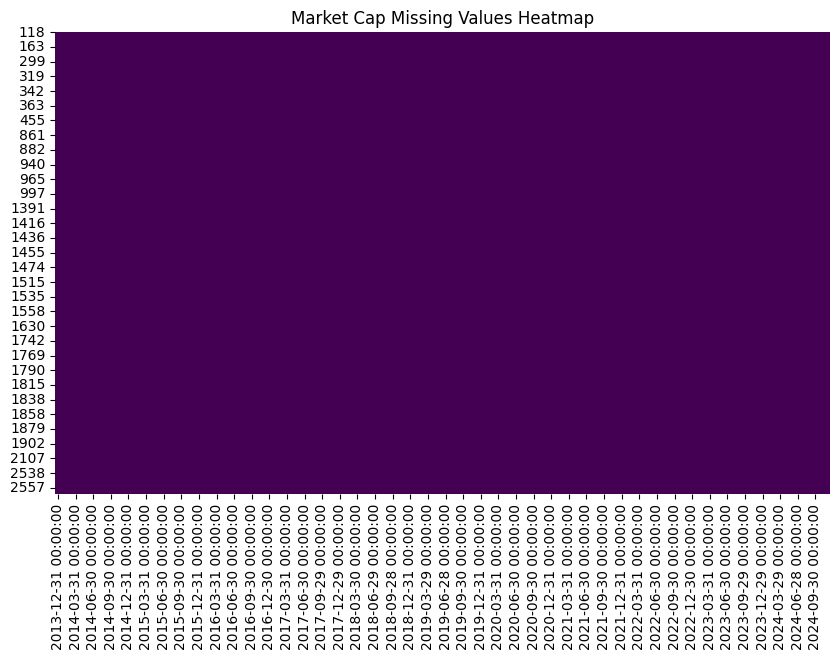

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(DS_MV_USD_M_2014_2024.isna(), cmap='viridis', cbar=False)
plt.title("Market Cap Missing Values Heatmap")
plt.show()

In [ ]:
rows_with_nans = DS_MV_USD_M_2014_2024[DS_MV_USD_M_2014_2024.isna().any(axis=1)]
rows_with_nans

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-02-29,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29


In [ ]:
if DS_MV_USD_M_2014_2024.index.isin(rows_with_nans.index).any():
    DS_MV_USD_M_2014_2024 = DS_MV_USD_M_2014_2024.drop(rows_with_nans.index)

In [ ]:
DS_MV_USD_M_2014_2024

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-02-29,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29
118,1170.70,1072.79,1103.84,939.92,876.95,827.57,811.38,874.92,889.02,805.15,...,41.21,39.83,36.82,36.81,35.25,32.20,37.15,39.19,50.41,42.16
146,114996.59,104071.17,113190.46,117679.20,114417.33,110958.88,112207.74,108525.20,114330.89,102799.57,...,39886.69,39309.19,36938.22,34658.22,32369.65,32280.60,35781.82,37847.65,34407.58,33596.80
147,29634.93,24716.57,25391.21,28952.72,30013.98,29087.67,32305.75,35054.33,44808.42,29594.35,...,33367.76,32411.79,30317.50,29570.88,27558.30,26916.82,28455.29,28602.67,26066.58,23775.07
148,25938.29,22723.27,24593.36,29077.23,31240.11,29269.99,30588.96,32131.64,38395.87,29919.18,...,14699.78,15132.55,14347.73,12805.03,11839.36,11680.45,14669.45,14338.50,13186.18,11236.44
149,18213.15,15577.58,16030.14,17515.29,19714.15,18752.00,21137.78,21370.09,23356.46,20743.13,...,5113.12,5485.47,5479.35,5947.72,6866.89,6268.28,7792.49,7306.66,7623.63,6991.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,239.61,219.97,236.29,245.64,244.33,273.06,263.71,260.31,258.23,232.88,...,220.68,239.09,248.89,280.70,295.36,388.98,393.90,413.00,427.45,460.04
2561,10704.38,9867.48,10464.15,12009.48,12396.91,12343.29,12869.13,13250.40,13278.13,11564.96,...,7625.44,6996.32,6906.91,7086.12,7760.90,7856.60,8858.64,9105.44,8530.48,8540.85
2562,1534.18,1482.66,1562.70,1471.59,1547.89,1596.54,1700.40,1632.78,1596.26,1295.70,...,2265.43,2363.04,2632.31,2730.05,2762.38,3107.39,2352.88,2507.23,2918.45,2467.31
2563,984.11,815.02,805.68,839.87,836.60,870.75,906.68,945.20,894.82,819.46,...,45.79,39.68,42.32,39.84,48.32,61.15,71.10,70.09,66.52,78.76


In [ ]:
if simple_returns_M_2014_2024.index.isin(rows_with_nans.index).any():
    simple_returns_M_2014_2024 = simple_returns_M_2014_2024.drop(rows_with_nans.index, errors='ignore')

if simple_returns_M_2014_2024_prev.index.isin(rows_with_nans.index).any():
    simple_returns_M_2014_2024_prev = simple_returns_M_2014_2024_prev.drop(rows_with_nans.index, errors='ignore')

if simple_returns_M_2014_2024_prev.index.isin(rows_with_nans_returns.index).any():
    simple_returns_M_2014_2024_prev = simple_returns_M_2014_2024_prev.drop(rows_with_nans_returns.index, errors='ignore')

### Equal-weights portfolio

In [ ]:
num_assets_per_month = simple_returns_M_2014_2024_prev.count(axis=0) # count total number of companies (N) in the previous month

equal_weights_df = pd.DataFrame([1/num_assets_per_month] * simple_returns_M_2014_2024.shape[0]) # create df that has weighting multiplier for the whole df, varying over months

DS_MV_USD_M_2014_2024_modified = DS_MV_USD_M_2014_2024.fillna(0).replace(np.nan, 0).applymap(lambda x: 1 if x != 0 else 0)

#equal_weights_df = equal_weights_df*DS_MV_USD_M_2014_2024_modified

equal_weights_df.columns = simple_returns_M_2014_2024.columns # adjust indices

simple_returns_M_2014_2024.reset_index(drop=True, inplace=True)

equal_weighted_returns_df = simple_returns_M_2014_2024 * equal_weights_df # matrix with the whole equal weighted returns

ew_portfolio_returns = equal_weighted_returns_df.sum(axis=0) # average monthly equal weighted return per month

ew_portfolio_returns = ew_portfolio_returns.reset_index()
ew_portfolio_returns.columns = ['date', 'ew_return']

ew_portfolio_returns

<ipython-input-122-91e597183446>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DS_MV_USD_M_2014_2024_modified = DS_MV_USD_M_2014_2024.fillna(0).replace(np.nan, 0).applymap(lambda x: 1 if x != 0 else 0)


,date,ew_return
0,2014-01-31,-0.051519
1,2014-02-28,0.030091
2,2014-03-31,0.044182
3,2014-04-30,0.012837
4,2014-05-30,0.036524
...,...,...
127,2024-08-30,0.022013
128,2024-09-30,0.051766
129,2024-10-31,-0.054013
130,2024-11-29,-0.024306


In [ ]:
equal_weighted_returns_df

,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,2014-10-31,...,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29,2024-12-31
0,-0.000148,0.000051,-0.000262,-0.000118,-0.000100,-0.000035,0.000138,0.000029,-0.000167,-0.000054,...,-0.000080,-0.000112,0.000000,-0.000090,-0.000158,0.000277,0.000090,0.000513,-0.000287,-0.000105
1,-0.000144,0.000155,0.000070,-0.000038,-0.000054,0.000020,-0.000041,0.000094,-0.000179,0.000062,...,-0.000026,-0.000107,-0.000109,-0.000117,-0.000005,0.000192,0.000102,-0.000161,-0.000042,-0.000106
2,-0.000293,0.000060,0.000281,0.000065,-0.000049,0.000219,0.000150,0.000497,-0.000587,0.000167,...,-0.000038,-0.000114,-0.000044,-0.000079,-0.000041,0.000133,0.000021,-0.000157,-0.000125,-0.000089
3,-0.000215,0.000151,0.000328,0.000136,-0.000108,0.000084,0.000094,0.000349,-0.000387,0.000128,...,0.000054,-0.000089,-0.000188,-0.000122,-0.000008,0.000469,-0.000028,-0.000128,-0.000249,-0.000193
4,-0.000243,0.000051,0.000164,0.000222,-0.000086,0.000225,0.000033,0.000164,-0.000198,0.000187,...,0.000129,-0.000002,0.000151,0.000273,-0.000154,0.000430,-0.000110,0.000077,-0.000108,-0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,-0.000145,0.000131,0.000070,-0.000009,0.000208,-0.000009,-0.000023,-0.000014,-0.000173,-0.000262,...,0.000147,0.000072,0.000225,0.000142,0.000560,0.000022,0.000086,0.000062,0.000173,0.000012
562,-0.000138,0.000107,0.000325,0.000057,-0.000008,0.000075,0.000052,0.000004,-0.000192,0.000275,...,-0.000146,0.000064,0.000046,0.000168,0.000022,0.000225,0.000125,-0.000112,0.000002,0.000094
563,-0.000124,0.000095,-0.000103,0.000091,0.000056,0.000115,-0.000070,-0.000040,-0.000333,-0.000100,...,0.000093,0.000201,0.000066,0.000021,0.000221,-0.000429,0.000128,0.000290,-0.000273,-0.000302
564,-0.000304,-0.000020,0.000075,-0.000007,0.000072,-0.000046,0.000075,-0.000094,-0.000149,-0.000119,...,-0.000294,0.000000,0.000000,0.000353,0.000589,0.000221,0.000000,-0.000196,0.000442,0.000000


### Value-weighted portfolio

In [ ]:
total_market_cap_per_month = DS_MV_USD_M_2014_2024.sum(axis=0) # total market cap of previous month (determined by data selection in data frame preparation)

market_cap_divider_df = pd.DataFrame([1/total_market_cap_per_month] * simple_returns_M_2014_2024.shape[0]) # matrix with 1/montly market cap to divide

market_cap_divider_df.reset_index(drop=True, inplace=True)

DS_MV_USD_M_2014_2024.reset_index(drop=True, inplace=True)

value_weights_df = DS_MV_USD_M_2014_2024 * market_cap_divider_df # matrix with monthly weighted assets

simple_returns_M_2014_2024.reset_index(drop=True, inplace=True)

value_weights_df.columns = simple_returns_M_2014_2024.columns # adjusting indices

value_weighted_returns_df = simple_returns_M_2014_2024 * value_weights_df # matrix with the whole value weighted returns

vw_portfolio_returns = value_weighted_returns_df.sum(axis=0) # average monthly value weighted return

vw_portfolio_returns = vw_portfolio_returns.reset_index()
vw_portfolio_returns.columns = ['date', 'vw_return']

vw_portfolio_returns

,date,vw_return
0,2014-01-31,-0.060380
1,2014-02-28,0.031644
2,2014-03-31,0.036572
3,2014-04-30,0.013129
4,2014-05-30,0.039535
...,...,...
127,2024-08-30,0.018401
128,2024-09-30,0.031769
129,2024-10-31,-0.043782
130,2024-11-29,-0.029044


In [ ]:
market_cap_divider_df

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-02-29,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29
0,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
1,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
2,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
3,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
4,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
562,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
563,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
564,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07


### Comparison value- vs equal-weights portfolio

In [ ]:
returns_df = pd.merge(ew_portfolio_returns, vw_portfolio_returns, on='date')

total_market_cap_df = total_market_cap_per_month.reset_index()
total_market_cap_df.columns = ['date', 'market_cap_total_prev_month']

returns_df = pd.merge(returns_df, total_market_cap_df, on='date', how='left')

# Number of assets based on market cap
num_assets_per_month_df = num_assets_per_month.reset_index()
num_assets_per_month_df.columns = ['date', 'num_assets_per_month']

returns_df = pd.merge(returns_df, num_assets_per_month_df, on='date', how='left')


# Number of assets based on return data
num_assets_per_month_return_data = DS_MV_USD_M_2014_2024.count(axis=0)

num_assets_per_month_return_data_df = num_assets_per_month_return_data.reset_index()
num_assets_per_month_return_data_df.columns = ['date', 'num_assets_per_month_return_data']

returns_df = pd.merge(returns_df, num_assets_per_month_return_data_df, on='date', how='left')

# Add risk free rate to df
returns_df['year_month'] = returns_df['date'].dt.to_period('M').astype(str)
risk_free_rate_df['year_month'] = risk_free_rate_df['date'].dt.to_period('M').astype(str)

returns_df = pd.merge(returns_df, risk_free_rate_df[['year_month', 'RF']], on='year_month', how='left')

# Adding squared difference to df
ew_return_average = returns_df['ew_return'].mean()
vw_return_average = returns_df['vw_return'].mean()

if 'ew_squared_difference_ew'not in returns_df.columns:
  returns_df['ew_squared_difference'] = ((returns_df['ew_return'] - ew_return_average) ** 2)
if 'vw_squared_difference_vw'not in returns_df.columns:
  returns_df['vw_squared_difference'] = ((returns_df['vw_return'] - vw_return_average) ** 2)

# Adding cumulative returns to df
if 'ew_cumulative_returns'not in returns_df.columns:
  returns_df['ew_cumulative_returns'] = ((1 + returns_df['ew_return']).cumprod() - 1)
if 'vw_cumulative_returns'not in returns_df.columns:
  returns_df['vw_cumulative_returns'] = ((1 + returns_df['vw_return']).cumprod() - 1)

if 'rf_cumulative_returns'not in returns_df.columns:
  returns_df['rf_cumulative_returns'] = ((1 + returns_df['RF']).cumprod() - 1)


returns_df

,date,ew_return,vw_return,market_cap_total_prev_month,num_assets_per_month,num_assets_per_month_return_data,year_month,RF,ew_squared_difference,vw_squared_difference,ew_cumulative_returns,vw_cumulative_returns,rf_cumulative_returns
0,2014-01-31,-0.051519,-0.060380,4.957478e+06,566.0,566.0,2014-01,0.0000,0.003424,0.004447,-0.051519,-0.060380,0.000000
1,2014-02-28,0.030091,0.031644,5.125215e+06,566.0,566.0,2014-02,0.0000,0.000533,0.000642,-0.022978,-0.030647,0.000000
2,2014-03-31,0.044182,0.036572,5.301491e+06,566.0,566.0,2014-03,0.0000,0.001383,0.000916,0.020189,0.004805,0.000000
3,2014-04-30,0.012837,0.013129,5.337481e+06,566.0,566.0,2014-04,0.0000,0.000034,0.000047,0.033285,0.017997,0.000000
4,2014-05-30,0.036524,0.039535,5.549771e+06,566.0,566.0,2014-05,0.0000,0.000872,0.001104,0.071025,0.058244,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2024-08-30,0.022013,0.018401,8.335877e+06,566.0,566.0,2024-08,0.0048,0.000225,0.000146,1.232197,1.097681,0.164355
128,2024-09-30,0.051766,0.031769,8.571947e+06,566.0,566.0,2024-09,0.0040,0.002004,0.000648,1.347748,1.164322,0.169012
129,2024-10-31,-0.054013,-0.043782,8.191666e+06,566.0,566.0,2024-10,0.0039,0.003722,0.002509,1.220940,1.069562,0.173571
130,2024-11-29,-0.024306,-0.029044,7.946311e+06,566.0,566.0,2024-11,0.0040,0.000980,0.001250,1.166958,1.009455,0.178265


### Visualizations

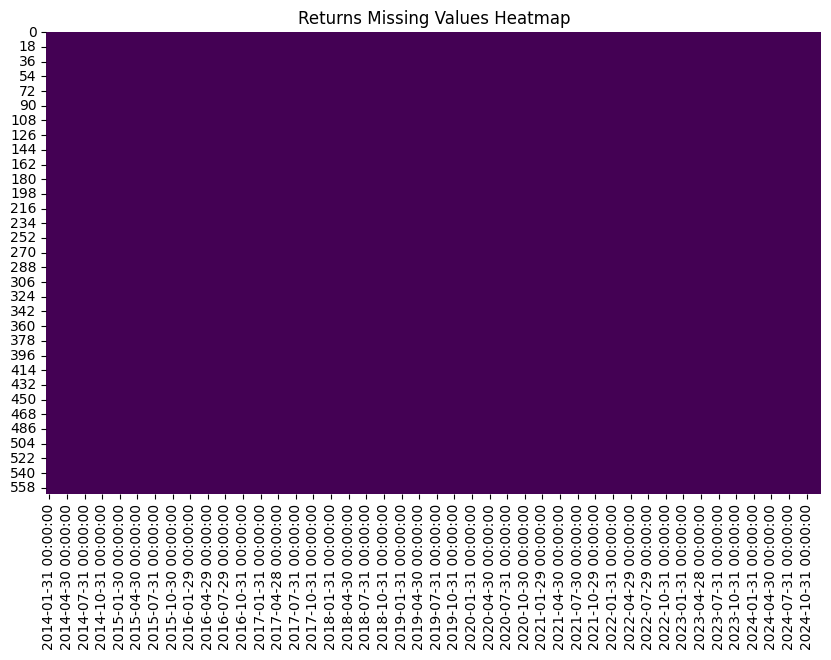

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(simple_returns_M_2014_2024.isna(), cmap='viridis', cbar=False)
plt.title("Returns Missing Values Heatmap")
plt.show()

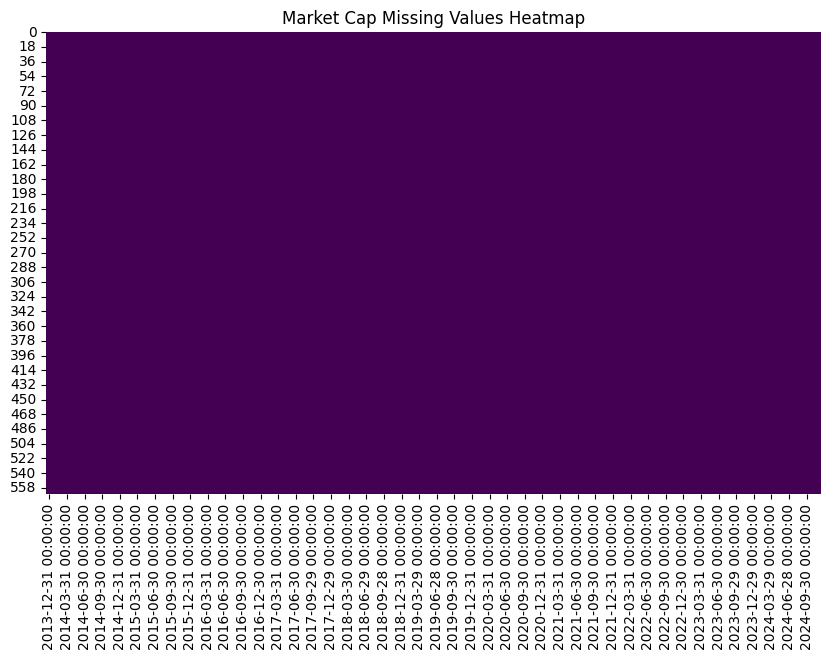

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(DS_MV_USD_M_2014_2024.isna(), cmap='viridis', cbar=False)
plt.title("Market Cap Missing Values Heatmap")
plt.show()

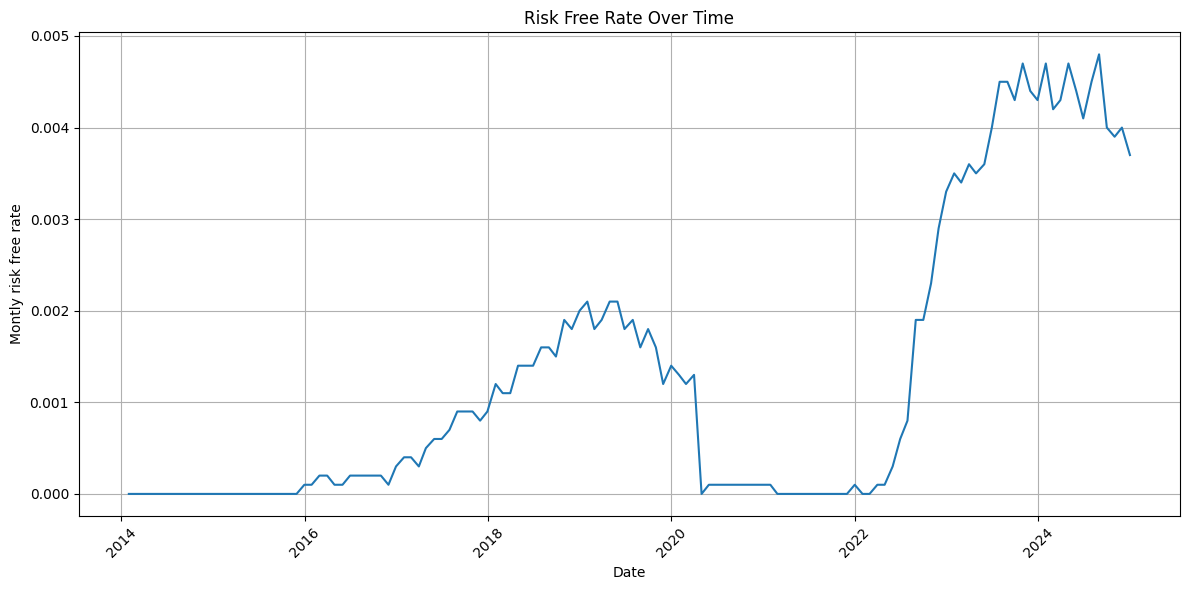

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(returns_df.date, returns_df.RF)
plt.xlabel('Date')
plt.ylabel('Montly risk free rate')
plt.title('Risk Free Rate Over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

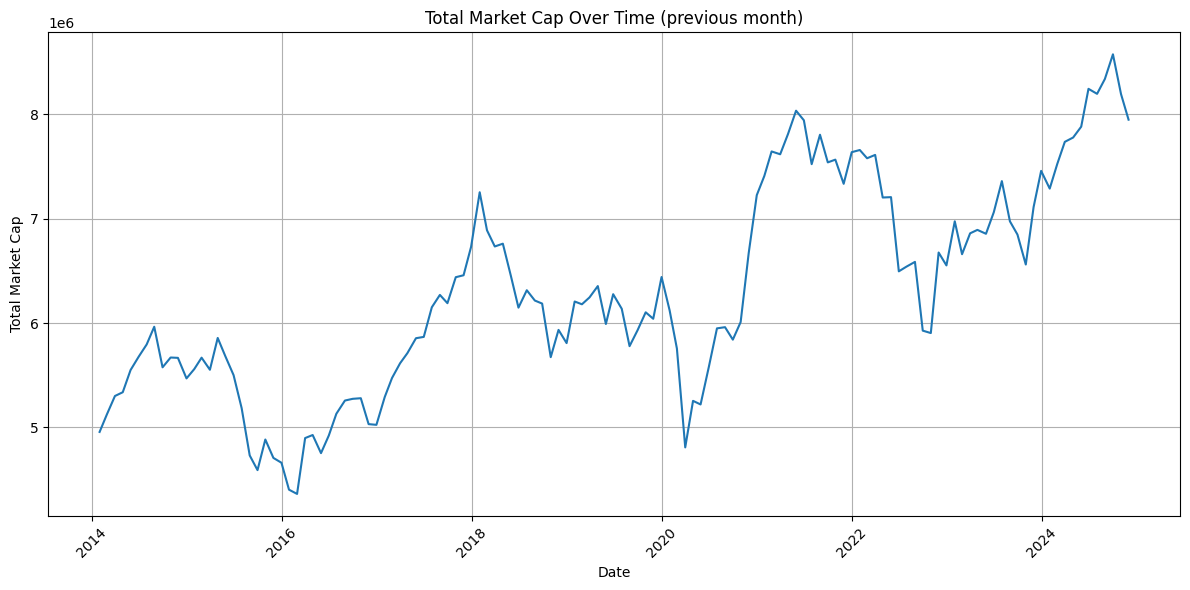

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(returns_df.date, returns_df.market_cap_total_prev_month)
plt.xlabel('Date')
plt.ylabel('Total Market Cap')
plt.title('Total Market Cap Over Time (previous month)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

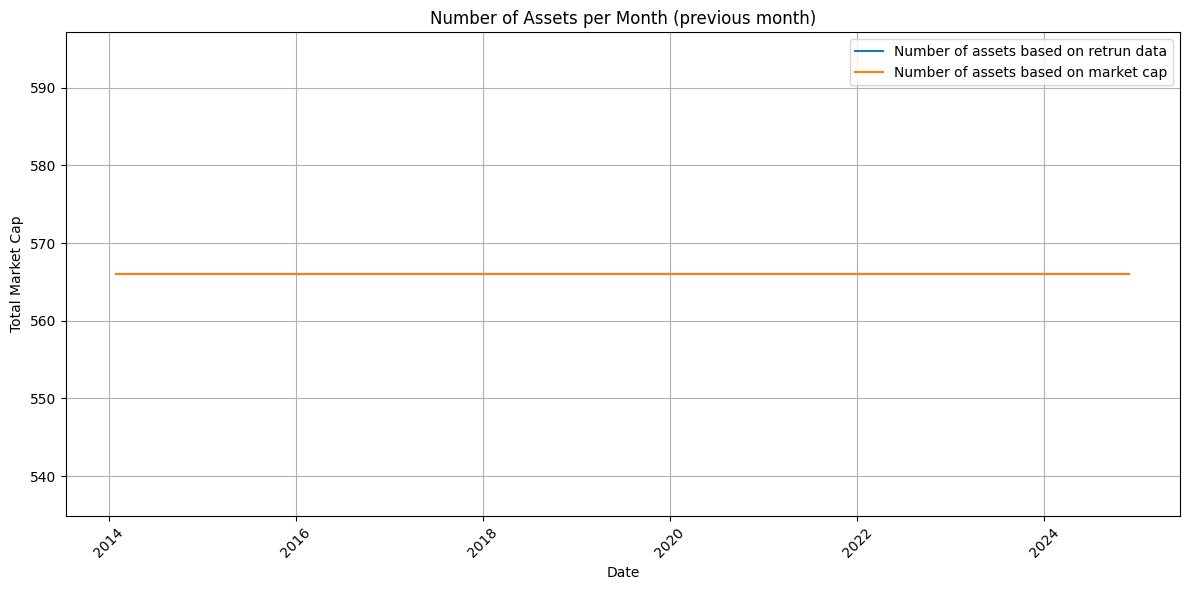

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(returns_df.date, returns_df.num_assets_per_month, label = 'Number of assets based on retrun data')
plt.plot(returns_df.date, returns_df.num_assets_per_month_return_data, label = 'Number of assets based on market cap')
plt.xlabel('Date')
plt.ylabel('Total Market Cap')
plt.title('Number of Assets per Month (previous month)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.legend()
plt.show()

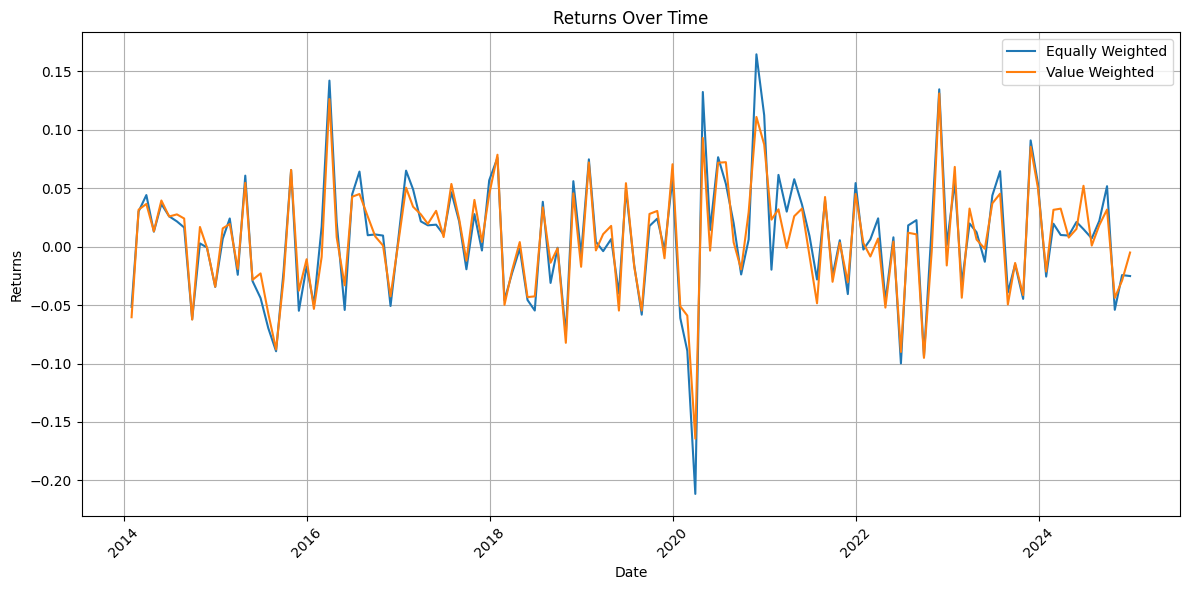

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(returns_df.date, returns_df.ew_return, label='Equally Weighted')
plt.plot(returns_df.date, returns_df.vw_return, label='Value Weighted')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns Over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.legend()  # Add the legend
plt.show()

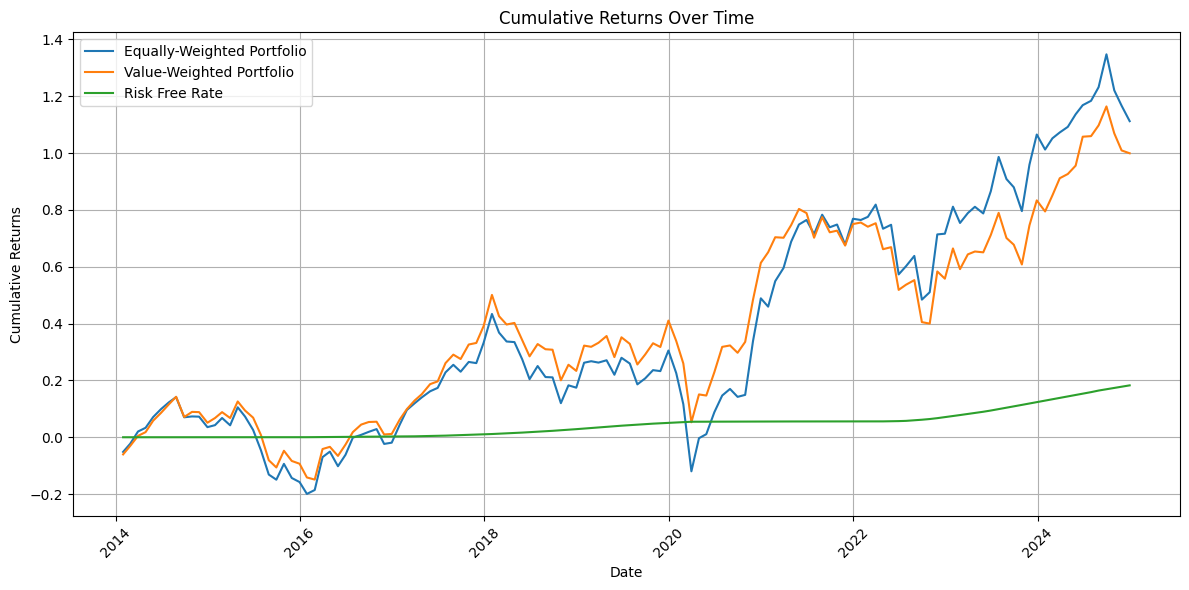

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(returns_df.date, returns_df.ew_cumulative_returns, label='Equally-Weighted Portfolio')
plt.plot(returns_df.date, returns_df.vw_cumulative_returns, label='Value-Weighted Portfolio')
plt.plot(returns_df.date, returns_df.rf_cumulative_returns, label='Risk Free Rate')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.legend()  # Add the legend
plt.show()

apparently normal behaviour, equally weighted portfolios usually have higher returns, but are more affected by a crisis

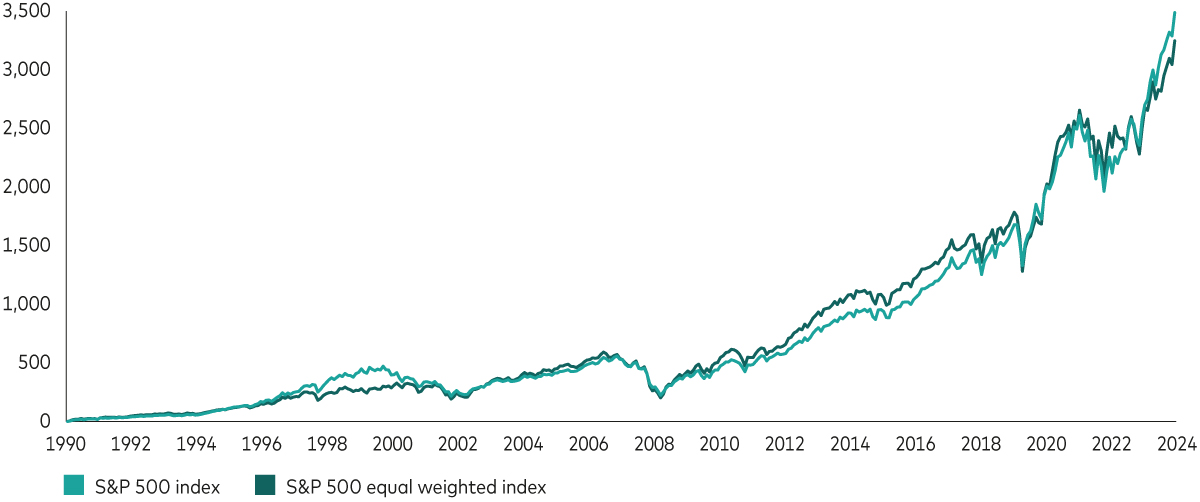

In [ ]:
total_return = (1 + returns_df['ew_return']).prod() - 1  # Cumulative product of returns

# Step 2: Count total months in the dataset
N = len(returns_df)

# Step 3: Annualize the return
ew_annualized_return = (1 + total_return) ** (12 / N) - 1

print(f"Annualized return of the equally weighted portfolio: {ew_annualized_return:.6f}")

Annualized return of the equally weighted portfolio: 0.070353


In [ ]:
total_return = (1 + returns_df['vw_return']).prod() - 1  # Cumulative product of returns

# Step 2: Count total months in the dataset
N = len(returns_df)

# Step 3: Annualize the return
vw_annualized_return = (1 + total_return) ** (12 / N) - 1

print(f"Annualized return of the value weighted portfolio: {vw_annualized_return:.6f}")

Annualized return of the value weighted portfolio: 0.065012


In [ ]:
min_ew_return = returns_df['ew_return'].min()
print(f"Minimum retrun in the equally weighted portfolio: {min_ew_return}")

Minimum retrun in the equally weighted portfolio: -0.21160288536489377


In [ ]:
min_vw_return = returns_df['vw_return'].min()
print(f"Minimum retrun in the value weighted portfolio: {min_vw_return}")

Minimum retrun in the value weighted portfolio: -0.16431603466928152


In [ ]:
max_ew_return = returns_df['ew_return'].max()
print(f"Maximum retrun in the equally weighted portfolio: {max_ew_return}")

Maximum retrun in the equally weighted portfolio: 0.16464744581338658


In [ ]:
max_vw_return = returns_df['vw_return'].max()
print(f"Maximum retrun in the value weighted portfolio: {max_vw_return}")

Maximum retrun in the value weighted portfolio: 0.13114685311295646


In [ ]:
import numpy as np

# Compute sample variance (N-1 for unbiased estimator)
ew_variance = returns_df['ew_squared_difference'].sum() / (len(returns_df))

# Convert variance to standard deviation (monthly volatility)
ew_volatility = np.sqrt(ew_variance)

# Annualize volatility (since returns are monthly, use sqrt(12))
ew_volatility_annualized = ew_volatility * np.sqrt(12)

# Print results
print(f"Annualized volatility of the equally-weighted portfolio: {ew_volatility_annualized}")

Annualized volatility of the equally-weighted portfolio: 0.1772330952512773


In [ ]:
import numpy as np

# Compute sample variance (N-1 for unbiased estimator)
vw_variance = returns_df['vw_squared_difference'].sum() / (len(returns_df))

# Convert variance to standard deviation (monthly volatility)
vw_volatility = np.sqrt(vw_variance)

# Annualize volatility (since returns are monthly, use sqrt(12))
vw_volatility_annualized = vw_volatility * np.sqrt(12)

# Print results
print(f"Annualized volatility of the value-weighted portfolio: {vw_volatility_annualized}")

Annualized volatility of the value-weighted portfolio: 0.1580432710109599


In [ ]:
df = returns_df

df['ew_excess_return'] = df['ew_return'] - df['RF']

# Calculate Sharpe Ratio
mean_excess_return = df['ew_excess_return'].mean()
std_excess_return = df['ew_excess_return'].std()

ew_sharpe_ratio = mean_excess_return / std_excess_return

print(f"Sharpe Ratio: {ew_sharpe_ratio:.4f}")

Sharpe Ratio: 0.1114


In [ ]:
ew_annualized_sharpe_ratio = ew_sharpe_ratio * np.sqrt(12)
print(f"Annualized Sharpe Ratio: {ew_annualized_sharpe_ratio:.4f}")

Annualized Sharpe Ratio: 0.3860


In [ ]:
df = returns_df

df['vw_excess_return'] = df['vw_return'] - df['RF']

# Calculate Sharpe Ratio
mean_excess_return = df['vw_excess_return'].mean()
std_excess_return = df['vw_excess_return'].std()

vw_sharpe_ratio = mean_excess_return / std_excess_return

print(f"Sharpe Ratio: {vw_sharpe_ratio:.4f}")

Sharpe Ratio: 0.1099


In [ ]:
vw_annualized_sharpe_ratio = vw_sharpe_ratio * np.sqrt(12)
print(f"Annualized Sharpe Ratio: {vw_annualized_sharpe_ratio:.4f}")

Annualized Sharpe Ratio: 0.3808


In [ ]:
# prompt: create a df with the above values to compare the two portfolios

import pandas as pd

data = {
    'Portfolio': ['Equally Weighted', 'Value Weighted'],
    'Annualized Return': [ew_annualized_return, vw_annualized_return],  # Replace with actual values
    'Minimum Return': [min_ew_return, min_vw_return],
    'Maximum Return': [max_ew_return, max_vw_return],
    'Annualized Volatility': [ew_volatility_annualized, vw_volatility_annualized],
    'Annualized Sharpe Ratio': [ew_annualized_sharpe_ratio, vw_annualized_sharpe_ratio]
}

df = pd.DataFrame(data)
summary_df = df

summary_df


,Portfolio,Annualized Return,Minimum Return,Maximum Return,Annualized Volatility,Annualized Sharpe Ratio
0,Equally Weighted,0.070353,-0.211603,0.164647,0.177233,0.385953
1,Value Weighted,0.065012,-0.164316,0.131147,0.158043,0.380816


## Question 3: Efficient frontier (35 points)

In [ ]:
import scipy.optimize as sco

In [ ]:
simple_returns_M_2014_2024_T = simple_returns_M_2014_2024.T

In [ ]:
returns_data = simple_returns_M_2014_2024_T
#num_assets = num_assets_per_month
cov_matrix = returns_data.cov()
num_assets = cov_matrix.shape[1]

In [ ]:
def port_vol(weights) :
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))

def port_ret(weights) :
  return np.sum(returns_data.mean() * weights)*12

def port_ret_neg(weights) :
  return -np.sum(returns_data.mean() * weights)*12

In [ ]:
cons = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1})

# Bounds Setup (non-negative weights)
bounds = [(0, None)] * num_assets

init_weights = np.array(num_assets*[1/num_assets])

opt_l_gmv = sco.minimize(port_vol, init_weights, method = 'SLSQP', bounds = bounds, constraints = cons)
opt_l_gmv

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.460958802596073e-05
       x: [ 3.229e-18  1.338e-16 ...  8.843e-07  3.631e-16]
     nit: 29
     jac: [ 1.025e-01  2.038e-02 ... -1.037e-01  1.599e-01]
    nfev: 16470
    njev: 29

In [ ]:
port_vol(opt_l_gmv['x'])

1.460958802596073e-05

In [ ]:
port_ret(opt_l_gmv['x'])

-2.437855044247175e-06

In [ ]:
cons = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1})

# Bounds Setup (non-negative weights)
bounds = [(0, None)] * num_assets

init_weights = np.array(num_assets*[1/num_assets])

opt_l_gmr = sco.minimize(port_ret_neg, init_weights, method = 'SLSQP', bounds = bounds, constraints = cons)
opt_l_gmr

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.5633006519696325
       x: [ 0.000e+00  0.000e+00 ...  1.262e-16  0.000e+00]
     nit: 6
     jac: [ 1.399e-01  3.643e-02 ...  3.090e-01  6.540e-02]
    nfev: 3402
    njev: 6

In [ ]:
port_vol(opt_l_gmr['x'])

0.6063101334185079

In [ ]:
port_ret(opt_l_gmr['x'])

0.5633006519696325

In [ ]:
mv_v = port_vol(opt_l_gmv['x'])
mv_r = port_ret(opt_l_gmv['x'])
mr_v = port_vol(opt_l_gmr['x'])
mr_r = port_ret(opt_l_gmr['x'])

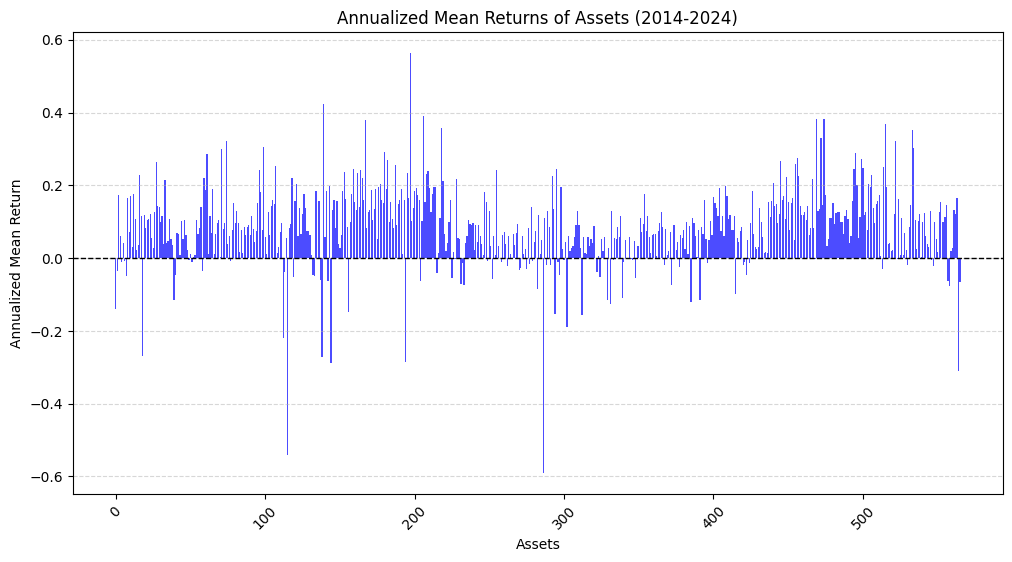

Mean Annualized Return Across Assets: 0.0839925177689467
Min Annualized Return: -0.5909090909090908
Max Annualized Return: 0.5633006519695752
Number of Negative Return Assets: 83


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `returns_data` is your dataframe with asset returns
# Step 1: Calculate annualized mean returns
annualized_returns = returns_data.mean() * 12

# Step 2: Create a bar plot to visualize returns of each asset
plt.figure(figsize=(12, 6))
plt.bar(annualized_returns.index, annualized_returns.values, alpha=0.7, color='blue')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Zero return line for reference

# Labels and title
plt.xlabel("Assets")
plt.ylabel("Annualized Mean Return")
plt.title("Annualized Mean Returns of Assets (2014-2024)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show plot
plt.show()

# Step 3: Print summary statistics
print("Mean Annualized Return Across Assets:", annualized_returns.mean())
print("Min Annualized Return:", annualized_returns.min())
print("Max Annualized Return:", annualized_returns.max())
print("Number of Negative Return Assets:", (annualized_returns < 0).sum())

In [ ]:
import numpy as np
import scipy.optimize as sco
from tqdm import tqdm

num_portfolios = 15

mu_hat = np.array(simple_returns_M_2014_2024.T.mean() * 12)
Sigma = np.array(cov_matrix * 12)

num_assets = len(mu_hat)

# Define portfolio volatility and return functions
def port_vol(weights):
    return np.sqrt(weights.T @ Sigma @ weights)

def port_ret(weights):
    return mu_hat @ weights

# Constraints and bounds
bounds = [(0, None)] * num_assets

# Generate target returns
values = np.linspace(mv_r, mr_r, num_portfolios)

# Store results
target_returns = []
optimized_volatility = []

init_guess = np.array([1/num_assets] * num_assets)

# Iterate with tqdm for status bar
for mu_target in tqdm(values, desc='Optimizing Portfolios'):
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'ineq', 'fun': lambda weights, mu_target=mu_target: port_ret(weights) - mu_target}
    ]

    result = sco.minimize(port_vol, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        optimized_volatility.append(result.fun)
        target_returns.append(mu_target)
    else:
        print(f"Optimization failed for target return {mu_target}: {result.message}")

# Convert results to arrays
target_returns = np.array(target_returns)
optimized_volatility = np.array(optimized_volatility)

# Report any missing portfolios due to optimization failure
missing = num_portfolios - len(target_returns)
if missing:
    print(f"Missing {missing}/{num_portfolios} optimizations due to failure.")

print("Target Returns:", target_returns)
print("Optimized Volatility:", optimized_volatility)


Optimizing Portfolios: 100%|██████████| 15/15 [02:18<00:00,  9.25s/it]

Target Returns: [-2.43785504e-06  4.02334971e-02  8.04694321e-02  1.20705367e-01
  1.60941302e-01  2.01177237e-01  2.41413172e-01  2.81649107e-01
  3.21885042e-01  3.62120977e-01  4.02356912e-01  4.42592847e-01
  4.82828782e-01  5.23064717e-01  5.63300652e-01]
Optimized Volatility: [4.88635089e-05 2.11797790e-02 4.23589888e-02 6.35396366e-02
 8.47201373e-02 1.05899728e-01 1.27257151e-01 1.51922688e-01
 1.82223953e-01 2.18967288e-01 2.65588204e-01 3.24278219e-01
 3.98114093e-01 4.91422653e-01 6.06310130e-01]


In [ ]:
# Calculate mean returns and covariance matrix for annualized data
mu_hat = np.array(simple_returns_M_2014_2024.T.mean() * 12)
Sigma = np.array(cov_matrix * 12)

num_assets = len(mu_hat)

# Define portfolio volatility and return functions
def port_vol(weights):
    return np.sqrt(weights.T @ Sigma @ weights)

def port_ret(weights):
    return mu_hat @ weights

# Constraints and bounds
bounds = [(0, None)] * num_assets

# Generate target returns
num_portfolios = 15
values = np.linspace(mv_r, mr_r, num_portfolios)

# Store results
target_returns = []
optimized_volatility = []
optimized_weights = []  # Store optimized weights for each portfolio

init_guess = np.array([1/num_assets] * num_assets)

# Iterate with tqdm for status bar
for mu_target in tqdm(values, desc='Optimizing Portfolios'):
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'ineq', 'fun': lambda weights, mu_target=mu_target: port_ret(weights) - mu_target}
    ]

    result = sco.minimize(port_vol, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        optimized_volatility.append(result.fun)
        target_returns.append(mu_target)
        optimized_weights.append(result.x)  # Store optimized weights
    else:
        print(f"Optimization failed for target return {mu_target}: {result.message}")

# Convert results to arrays
target_returns = np.array(target_returns)
optimized_volatility = np.array(optimized_volatility)
optimized_weights = np.array(optimized_weights)

# Report any missing portfolios due to optimization failure
missing = num_portfolios - len(target_returns)
if missing:
    print(f"Missing {missing}/{num_portfolios} optimizations due to failure.")

# Calculate ex-post annualized average return for each portfolio
ex_post_annualized_returns = np.array([port_ret(weights) for weights in optimized_weights])

# Calculate ex-post annualized volatility for each portfolio
ex_post_annualized_volatility = np.array([port_vol(weights) for weights in optimized_weights])

# Calculate ex-post annualized Sharpe ratio for each portfolio
risk_free_rate = 0.02  # Annual risk-free rate
ex_post_sharpe_ratios = (ex_post_annualized_returns - risk_free_rate) / ex_post_annualized_volatility

# Display results
print("Target Returns:", target_returns)
print("Optimized Volatility:", optimized_volatility)
print("Ex-post Annualized Returns:", ex_post_annualized_returns)
print("Ex-post Annualized Volatility:", ex_post_annualized_volatility)
print("Ex-post Annualized Sharpe Ratios:", ex_post_sharpe_ratios)

Optimizing Portfolios: 100%|██████████| 15/15 [02:17<00:00,  9.17s/it]

Target Returns: [-2.43785504e-06  4.02334971e-02  8.04694321e-02  1.20705367e-01
  1.60941302e-01  2.01177237e-01  2.41413172e-01  2.81649107e-01
  3.21885042e-01  3.62120977e-01  4.02356912e-01  4.42592847e-01
  4.82828782e-01  5.23064717e-01  5.63300652e-01]
Optimized Volatility: [4.88635089e-05 2.11797790e-02 4.23589888e-02 6.35396366e-02
 8.47201373e-02 1.05899728e-01 1.27257151e-01 1.51922688e-01
 1.82223953e-01 2.18967288e-01 2.65588204e-01 3.24278219e-01
 3.98114093e-01 4.91422653e-01 6.06310130e-01]
Ex-post Annualized Returns: [1.95223524e-05 4.02334971e-02 8.04694321e-02 1.20705367e-01
 1.60941302e-01 2.01177237e-01 2.41413172e-01 2.81649107e-01
 3.21885042e-01 3.62120977e-01 4.02356912e-01 4.42592847e-01
 4.82828782e-01 5.23064717e-01 5.63300651e-01]
Ex-post Annualized Volatility: [4.88635089e-05 2.11797790e-02 4.23589888e-02 6.35396366e-02
 8.47201373e-02 1.05899728e-01 1.27257151e-01 1.51922688e-01
 1.82223953e-01 2.18967288e-01 2.65588204e-01 3.24278219e-01
 3.98114093e-01

In [ ]:
# Create a DataFrame from the calculated ex-post metrics
ex_post_df = pd.DataFrame({
    'Ex-post Annualized Return': ex_post_annualized_returns,
    'Ex-post Annualized Volatility': ex_post_annualized_volatility,
    'Ex-post Annualized Sharpe Ratio': ex_post_sharpe_ratios
})

# Display the DataFrame
ex_post_df

,Ex-post Annualized Return,Ex-post Annualized Volatility,Ex-post Annualized Sharpe Ratio
0,0.000020,0.000049,-408.903865
1,0.040233,0.021180,0.955321
2,0.080469,0.042359,1.427547
3,0.120705,0.063540,1.584922
4,0.160941,0.084720,1.663610
5,0.201177,0.105900,1.710838
6,0.241413,0.127257,1.739888
7,0.281649,0.151923,1.722252
8,0.321885,0.182224,1.656670
9,0.362121,0.218967,1.562430


In [ ]:
# Convert the 'date' column to datetime objects if it's not already
risk_free_rate_df['date'] = pd.to_datetime(risk_free_rate_df['date'])

# Filter the DataFrame for the specified date range
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2024-12-31')
filtered_df = risk_free_rate_df[(risk_free_rate_df['date'] >= start_date) & (risk_free_rate_df['date'] <= end_date)]

# Calculate the average risk-free rate
average_risk_free_rate = filtered_df['RF'].mean()

print(f"The average risk-free rate from 2014-01-01 to 2024-12-31 is: {average_risk_free_rate}")

The average risk-free rate from 2014-01-01 to 2024-12-31 is: 0.0012727272727272728


In [ ]:
# Example asset return and covariance matrix (replace with real data)
expected_returns = np.array(simple_returns_M_2014_2024.T.mean() * 12)
cov_matrix = np.array(cov_matrix * 12)

rf_rate = average_risk_free_rate  # Annual risk-free rate

# Portfolio performance functions
def portfolio_return(weights):
    return np.dot(weights, expected_returns)

def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights):
    return -(portfolio_return(weights) - rf_rate) / portfolio_volatility(weights)  # Negative for minimization

num_assets = len(expected_returns)
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Constraint: Weights sum to 1
bounds = [(0, 1)] * num_assets  # Weights between 0 and 1 (long-only)
init_weights = np.array(num_assets * [1 / num_assets])  # Equal initial weights

opt_sharpe = sco.minimize(sharpe_ratio, init_weights, method='SLSQP', bounds=bounds, constraints=cons)

# Extract optimal weights
opt_weights = opt_sharpe.x
opt_return = portfolio_return(opt_weights)
opt_volatility = portfolio_volatility(opt_weights)
opt_sharpe_ratio = -opt_sharpe.fun  # Convert back to positive

# Print results
print("Optimal Portfolio Weights:", opt_weights)
print("Expected Return:", opt_return)
print("Expected Volatility:", opt_volatility)
print("Sharpe Ratio:", opt_sharpe_ratio)

Optimal Portfolio Weights: [9.93274655e-14 6.57957807e-14 6.14149613e-14 8.03359797e-14
 1.12040500e-13 8.39660081e-14 7.30589840e-14 1.62175930e-15
 3.37563821e-14 3.37369797e-14 2.83721873e-14 1.47435387e-13
 1.09620492e-13 6.88922212e-14 6.66655534e-14 6.47838547e-14
 8.36397406e-14 7.49232476e-15 2.52514119e-13 1.76802150e-13
 2.43109647e-13 2.36722118e-13 4.12363495e-14 1.77197633e-14
 2.24464637e-13 2.98073642e-13 4.55928313e-14 1.11145868e-13
 2.47232383e-14 2.91721028e-13 2.65489686e-13 2.22922143e-14
 8.09594516e-14 5.92059828e-14 4.26017686e-14 2.26242219e-14
 3.02559905e-13 2.37947333e-14 1.84615011e-13 2.54500044e-14
 8.60761573e-14 2.01570749e-13 4.18987698e-15 4.11862659e-14
 8.74018003e-14 2.15338383e-13 1.54470312e-13 4.59115625e-14
 9.62807530e-15 3.04061540e-15 5.20976518e-14 1.03668175e-13
 4.02651130e-14 1.07806504e-13 7.26402722e-14 4.05891201e-14
 2.43592900e-13 3.11595998e-13 7.45589145e-14 1.79297342e-13
 2.77919155e-13 1.66389995e-14 2.20007557e-13 2.47946004e-

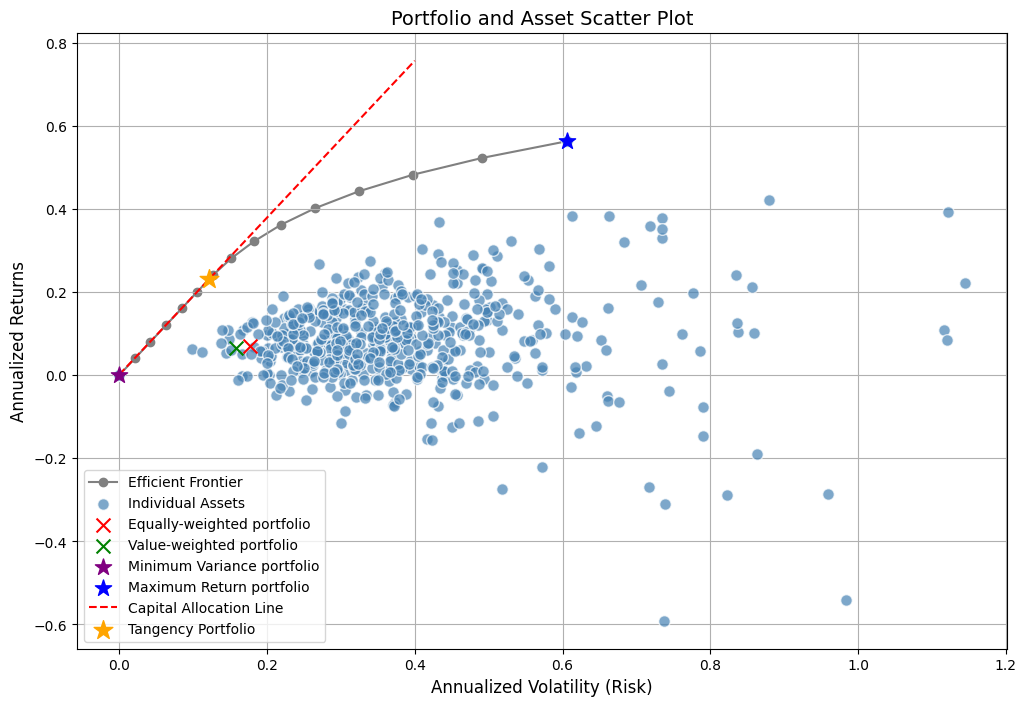

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
#from pypfopt.efficient_frontier import EfficientFrontier
#from pypfopt.risk_models import CovarianceShrinkage
#from pypfopt.expected_returns import mean_historical_return
#from pypfopt.cla import CLA
#from pypfopt.plotting import plot_efficient_frontier, plot_weights

# Annualized returns and volatility for individual assets
asset_returns = returns_data.mean() * 12
asset_volatility = returns_data.std() * np.sqrt(12)

df = simple_returns_M_2014_2024.T
df.index = pd.to_datetime(df.index)

mu = df.mean()*12
S = df.cov()*12

#ef = EfficientFrontier(mu, S, weight_bounds=(0, 1), solver=None, verbose=False, solver_options=None)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

#plot_efficient_frontier(ef, ax=ax, show_assets=False)
#frontier_line = ax.lines[0]  # efficient frontier is typically the first line
#frontier_line.set_color('black')

# Efficient frontier (lowest layer)
ax.plot(optimized_volatility, target_returns, marker='o', linestyle='-',
        linewidth=1.5, color='grey', label='Efficient Frontier', zorder=1)

# Individual assets (above the efficient frontier)
ax.scatter(asset_volatility, asset_returns,
           marker='o', s=70, color='steelblue', alpha=0.7,
           edgecolors='w', linewidths=1, label='Individual Assets', zorder=2)

# Equally-weighted portfolio
ax.scatter(summary_df.iloc[0, 4], summary_df.iloc[0, 1],
           marker='x', s=100, c='red', label='Equally-weighted portfolio', zorder=3)

# Value-weighted portfolio
ax.scatter(summary_df.iloc[1, 4], summary_df.iloc[1, 1],
           marker='x', s=100, c='green', label='Value-weighted portfolio', zorder=3)

# Minimum variance portfolio
ax.scatter(mv_v, mv_r,
           marker='*', s=150, c='purple', label='Minimum Variance portfolio', zorder=4)

# Maximum return portfolio
ax.scatter(mr_v, mr_r,
           marker='*', s=150, c='blue', label='Maximum Return portfolio', zorder=4)


x_cal = np.linspace(0, 0.4, 100)  # Extend CAL beyond the efficient frontier
y_cal = rf_rate + (opt_sharpe_ratio * x_cal)  # Equation of the CAL

plt.plot(x_cal, y_cal, label="Capital Allocation Line", linestyle='dashed', color='red')

# Plot Tangency Portfolio (Optimal Portfolio)
plt.scatter(opt_volatility, opt_return, marker="*", color="orange", s=200, label="Tangency Portfolio", zorder=5)




# Set titles and labels
ax.set_title("Portfolio and Asset Scatter Plot", fontsize=14)
ax.set_xlabel("Annualized Volatility (Risk)", fontsize=12)
ax.set_ylabel("Annualized Returns", fontsize=12)

# Add legend
ax.legend()

# Display the plot
plt.grid(True)
plt.show()


### Efficient frontier

## Question 4: Minimum variance portfolio (40 points)